In [94]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from descartes import PolygonPatch
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
import numpy as np
import requests
import folium
from requests.adapters import HTTPAdapter, Retry

**!!UWAGA!!** Instalujemy najnowsze paczki, jednak descartes nie zrobiło uaktualnienia pod najnowszą wersję shapely, dlatego, żeby notebook działał należy w kodzie źródłowym descartes w patch.py w 62 linii zmienić **t.exterior** na **t.exterior.coords** [żródło](https://stackoverflow.com/questions/75287534/indexerror-descartes-polygonpatch-wtih-shapely).

(zmiany dokonuje się w env/lib/python/descartes)

# OSMNX Features

Ten notebook prezentuje możliwości wykorzystania OSMNX, w tym:
* budowanie i prezentację grafu ulic
* statystyki i nadawanie atrybutów krawędzi
* routing
* próbę budowania grafu z samych obiektów np. budynki
* tworzenie GeoDataFrame na podstawie wybranych tagów z zadanego obszaru
* mapy izochroniczne
* pozyskiwanie danych historycznych
* R-tree spatial indexing
* Network-based spatial clustering
* Wyznaczanie trasy pieszej pomiędzy dwoma punktami
* Przykład użycia grafu ulic zaimplementowanego w ramach modułu graph_creation

## Podstawowy graf ulic


OSMnx geokoduje zapytanie "Wrocław, Poland", aby pobrać granice tego miasta z interfejsu API Nominatim, pobiera dane sieci ulic w tych granicach z interfejsu API Overpass, konstruuje model grafu, a następnie upraszcza / koryguje jego topologię w taki sposób, że węzły reprezentują skrzyżowania i ślepe zaułki, a krawędzie reprezentują łączące je odcinki ulic. 
Upraszczając jescze - węzły są punktami a krawędzie to łączące je Linestringi.

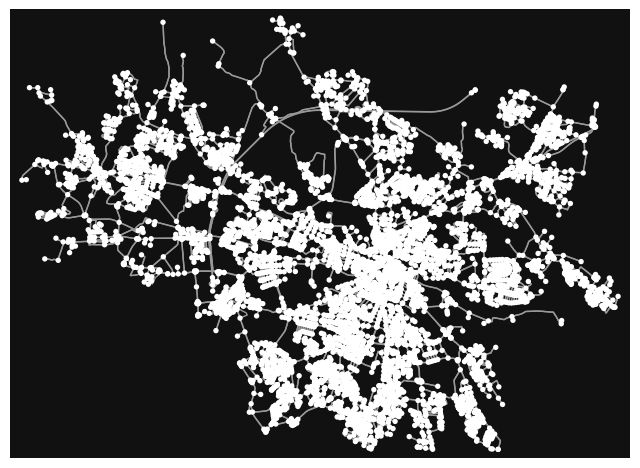

In [2]:
G = ox.graph_from_place("Wrocław, Poland", network_type="drive") # typ nx.MultiDiGraph lub None
fig, ax = ox.plot_graph(G)


In [3]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()  # type: ignore

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
95584835,51.083111,17.049513,4,NaN,NaN,POINT (17.04951 51.08311)
95584841,51.084699,17.064367,3,NaN,NaN,POINT (17.06437 51.08470)
95584850,51.083328,17.035057,4,NaN,NaN,POINT (17.03506 51.08333)
95584852,51.083009,17.053573,4,NaN,NaN,POINT (17.05357 51.08301)
95584855,51.083333,17.034685,4,NaN,NaN,POINT (17.03468 51.08333)


In [4]:
gdf_edges.head()  # type: ignore

osmid  oneway lanes  \
u        v         key                                        
95584835 297779709 0    [24707867, 656793686]    True     2   
         241778108 0    [656794402, 28458110]    True     2   
95584841 164895026 0                 27665976   False   NaN   
         268480775 0                304583916    True     2   
95584850 95584855  0                 28458082    True     3   

                                              name       highway maxspeed  \
u        v         key                                                      
95584835 297779709 0                       Bardzka      tertiary       50   
         241778108 0          Aleja Armii Krajowej       primary       50   
95584841 164895026 0    Biskupa Bernarda Bogedaina  unclassified      NaN   
         268480775 0          Aleja Armii Krajowej       primary       50   
95584850 95584855  0          Aleja Armii Krajowej       primary       50   

                       reversed   length  \
u        v         key                     
95584835 297779709 0      False  178.450   
         241778108 0      False   30.730   
95584841 164895026 0      False   14.714   
         268480775 0      False  125.913   
95584850 95584855  0      False   25.991   

                                                                 geometry  \
u        v         key                                                      
95584835 297779709 0    LINESTRING (17.04951 51.08311, 17.04947 51.083...   
         241778108 0    LINESTRING (17.04951 51.08311, 17.04933 51.083...   
95584841 164895026 0    LINESTRING (17.06437 51.08470, 17.06450 51.08460)   
         268480775 0    LINESTRING (17.06437 51.08470, 17.06412 51.084...   
95584850 95584855  0    LINESTRING (17.03506 51.08333, 17.03468 51.08333)   

                        ref access bridge junction width tunnel  
u        v         key                                           
95584835 297779709 0    NaN    NaN    NaN      NaN   NaN    NaN  
         241778108 0     94    NaN    NaN      NaN   NaN    NaN  
95584841 164895026 0    NaN    NaN    NaN      NaN   NaN    NaN  
         268480775 0     94    NaN    NaN      NaN   NaN    NaN  
95584850 95584855  0     94    NaN    NaN      NaN   NaN    NaN

Można też stworzyć graf z node/edge gdf dopóki wierzchołki są indeksowane przez osmid a krawędzie są multi indeksowane przez y, v, key (struktura MultiDiGraph).

In [5]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

### Statystyki

In [6]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area # type: ignore
graph_area_m

319240693.8519159

In [7]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 7169,
 'm': 16873,
 'k_avg': 4.707211605523783,
 'edge_length_total': 2394325.5450000144,
 'edge_length_avg': 141.90277632904727,
 'streets_per_node_avg': 2.775561445110894,
 'streets_per_node_counts': {0: 0,
  1: 1240,
  2: 134,
  3: 4837,
  4: 913,
  5: 43,
  6: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1729669409959548,
  2: 0.018691588785046728,
  3: 0.6747105593527689,
  4: 0.12735388478169898,
  5: 0.005998047147440368,
  6: 0.0002789789370902497},
 'intersection_count': 5929,
 'street_length_total': 1378766.5179999976,
 'street_segment_count': 9930,
 'street_length_avg': 138.848591943605,
 'circuity_avg': 1.049298193098589,
 'self_loop_proportion': 0.0028197381671701913,
 'clean_intersection_count': 4482,
 'node_density_km': 22.456410282473062,
 'intersection_density_km': 18.57219369016359,
 'edge_density_km': 7500.063717160865,
 'street_density_km': 4318.893375916408,
 'clean_intersection_density_km': 14.039563521557298}

### Edge centrality

Nadane atrybuty krawędzi, takie jak centralność krawędzi można w dość prosty sposób zwizualizować dedykowaną funkcją. Za pomocą biblioteki NetworkX nadaje się atrybuty, a następnie odwołuje do nich w merodzie z OSMNX.

In [8]:
# street centrality
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

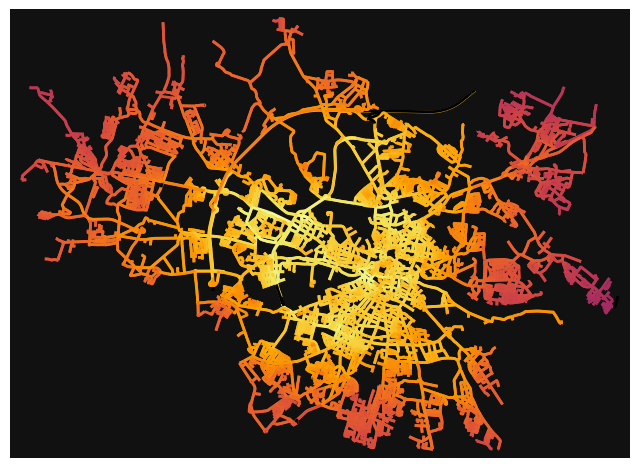

In [9]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno") # type: ignore
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

### Routing

OSMNX pozwala na znajdowanie najkrótszej trasy pomiędzy wierzchołkami, określanie długości drogi, czy też wysokości (elevation)

NOTE: Elevation może być realizowane poprzez odpowiedni lokalny plik lub [Google Maps Elevation API](https://developers.google.com/maps/documentation/elevation/overview?hl=pl) (potrzebny klucz)

In [10]:
# impute missing edge speeds and calculate edge travel times with the speed module 
# (https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.speed.add_edge_speeds)
G = ox.speed.add_edge_speeds(G) # type: ignore
G = ox.speed.add_edge_travel_times(G) # type: ignore

In [11]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges

osmid  oneway lanes  \
u           v          key                                           
95584835    297779709  0       [24707867, 656793686]    True     2   
            241778108  0       [656794402, 28458110]    True     2   
95584841    164895026  0                    27665976   False   NaN   
            268480775  0                   304583916    True     2   
95584850    95584855   0                    28458082    True     3   
...                                              ...     ...   ...   
11219422358 9429542220 0    [1207115442, 1210930875]   False   NaN   
11315118536 4084010776 0                   406316282   False   NaN   
11352506799 5894904107 0      [378490349, 745309237]   False   NaN   
            6976675773 0                   745309237   False   NaN   
            9121881278 0                  1223946531    True   NaN   

                                                  name        highway  \
u           v          key                                              
95584835    297779709  0                       Bardzka       tertiary   
            241778108  0          Aleja Armii Krajowej        primary   
95584841    164895026  0    Biskupa Bernarda Bogedaina   unclassified   
            268480775  0          Aleja Armii Krajowej        primary   
95584850    95584855   0          Aleja Armii Krajowej        primary   
...                                                ...            ...   
11219422358 9429542220 0                           NaN    residential   
11315118536 4084010776 0                      Jeżowska    residential   
11352506799 5894904107 0              Beaty Artemskiej    residential   
            6976675773 0              Beaty Artemskiej    residential   
            9121881278 0                           NaN  living_street   

                           maxspeed reversed   length  \
u           v          key                              
95584835    297779709  0         50    False  178.450   
            241778108  0         50    False   30.730   
95584841    164895026  0        NaN    False   14.714   
            268480775  0         50    False  125.913   
95584850    95584855   0         50    False   25.991   
...                             ...      ...      ...   
11219422358 9429542220 0        NaN    False  316.729   
11315118536 4084010776 0        NaN    False   47.364   
11352506799 5894904107 0        NaN    False  140.111   
            6976675773 0        NaN     True   87.326   
            9121881278 0        NaN    False  119.830   

                                                                     geometry  \
u           v          key                                                      
95584835    297779709  0    LINESTRING (17.04951 51.08311, 17.04947 51.083...   
            241778108  0    LINESTRING (17.04951 51.08311, 17.04933 51.083...   
95584841    164895026  0    LINESTRING (17.06437 51.08470, 17.06450 51.08460)   
            268480775  0    LINESTRING (17.06437 51.08470, 17.06412 51.084...   
95584850    95584855   0    LINESTRING (17.03506 51.08333, 17.03468 51.08333)   
...                                                                       ...   
11219422358 9429542220 0    LINESTRING (17.10463 51.14458, 17.10467 51.144...   
11315118536 4084010776 0    LINESTRING (16.90342 51.14250, 16.90407 51.14238)   
11352506799 5894904107 0    LINESTRING (17.05234 51.05584, 17.05298 51.055...   
            6976675773 0    LINESTRING (17.05234 51.05584, 17.05233 51.055...   
            9121881278 0    LINESTRING (17.05234 51.05584, 17.05233 51.055...   

                            edge_centrality  speed_kph  travel_time  ref  \
u           v          key                                                 
95584835    297779709  0           0.022291       50.0         12.8  NaN   
            241778108  0           0.022290       50.0          2.2   94   
95584841    164895026  0           0.021688       36.6          1.4  NaN   
          

Jak widać wyżej pojawiły się atrybuty krawędzi takie jak travel_time czy speed

## Inne typy sieci

W tej sekcji nastapiłą próba budowania grafu z wykorzystaniem tylko obiektów takich jak budynki. Część raczej do przejrzenia i zapoznania się z funkcjonalnością custom filter niż realnego budowania grafu w ten sposób w przyszłości. Custom ilter warto stosować w przypadku odfiltrowania typów dróg/połączeń będących obszarem zainteresowania.

In [12]:
"""
network_type : string {"all_private", "all", "bike", "drive", "drive_service", "walk"}
        what type of street network to get if custom_filter is None
custom_filter : string
        a custom ways filter to be used instead of the network_type presets
        e.g., '["power"~"line"]' or '["highway"~"motorway|trunk"]'. Also pass
        in a network_type that is in settings.bidirectional_network_types if
        you want graph to be fully bi-directional.

 UWAGA - custom_filter musi być jakąś siecią (amenity np. nie każde działa)
"""
cf = '["building"~"residential"]'
G = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
len(G)

34

In [13]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()  # type: ignore

,y,x,street_count,geometry
osmid,,,,
6239391508,51.047053,17.026246,4,POINT (17.02625 51.04705)
6239391509,51.047076,17.026064,4,POINT (17.02606 51.04708)
6239391510,51.047116,17.026292,4,POINT (17.02629 51.04712)
6239391511,51.047145,17.026064,4,POINT (17.02606 51.04714)
1164364310,51.046984,17.026250,4,POINT (17.02625 51.04698)


In [14]:
gdf_edges.head()

osmid  oneway  reversed  length  \
u          v          key                                        
6239391508 6239391509 0    264895720   False     False  12.939   
                      1    666427880   False      True  12.939   
           6239391510 0    264895720   False      True   9.226   
           1164364310 0    666427880   False     False   9.287   
6239391509 6239391508 0    264895720   False      True  12.939   

                                                                    geometry  
u          v          key                                                     
6239391508 6239391509 0    LINESTRING (17.02625 51.04705, 17.02606 51.04708)  
                      1    LINESTRING (17.02625 51.04705, 17.02606 51.04708)  
           6239391510 0    LINESTRING (17.02625 51.04705, 17.02626 51.047...  
           1164364310 0    LINESTRING (17.02625 51.04705, 17.02623 51.047...  
6239391509 6239391508 0    LINESTRING (17.02606 51.04708, 17.02625 51.04705)

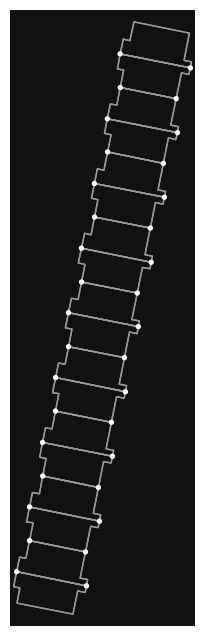

In [15]:
fig, ax = ox.plot_graph(G)

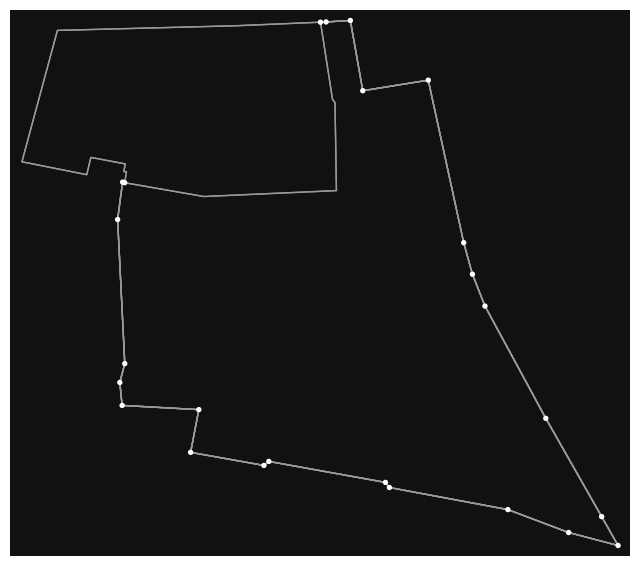

In [16]:
cf = '["amenity"~"school"]'
G3 = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
fig, ax = ox.plot_graph(G3)

In [17]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G3)
gdf_nodes.head()  # type: ignore

,y,x,street_count,geometry
osmid,,,,
5455005701,51.106097,17.093695,4,POINT (17.09370 51.10610)
5455005702,51.106102,17.093832,4,POINT (17.09383 51.10610)
5455005703,51.105853,17.093902,4,POINT (17.09390 51.10585)
5455005704,51.105890,17.094272,4,POINT (17.09427 51.10589)
5455005705,51.105089,17.094592,4,POINT (17.09459 51.10509)


In [18]:
gdf_edges

osmid                               name  \
u          v          key                                                  
5455005701 3833463378 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
           5455005702 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
5455005702 5455005701 0     569017499            Szkoła Podstawowa nr 66   
...                               ...                                ...   
3833463378 3833463366 1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
4315060592 5455005704 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   
           3896780344 0     569017499            Szkoła Podstawowa nr 66   
                      1    1037300780  Zespół Szkolno-Przedszkolny Nr 22   

                             landuse  oneway  reversed   length  \
u          v          key                                         
5455005701 3833463378 0    education   False     False    2.208   
                      1    education   False      True    2.208   
           5455005702 0    education   False      True    9.582   
                      1    education   False     False    9.582   
5455005702 5455005701 0    education   False     False    9.582   
...                              ...     ...       ...      ...   
3833463378 3833463366 1    education   False      True  212.811   
4315060592 5455005704 0    education   False     False   65.565   
                      1    education   False      True   65.565   
           3896780344 0    education   False      True   12.910   
                      1    education   False     False   12.910   

                                                                    geometry  
u          v          key                                                     
5455005701 3833463378 0    LINESTRING (17.09370 51.10610, 17.09366 51.10610)  
                      1    LINESTRING (17.09370 51.10610, 17.09366 51.10610)  
           5455005702 0    LINESTRING (17.09370 51.10610, 17.09383 51.10610)  
                      1    LINESTRING (17.09370 51.10610, 17.09383 51.10610)  
5455005702 5455005701 0    LINESTRING (17.09383 51.10610, 17.09370 51.10610)  
...                                                                      ...  
3833463378 3833463366 1    LINESTRING (17.09366 51.10610, 17.09318 51.106...  
4315060592 5455005704 0    LINESTRING (17.09447 51.10531, 17.09427 51.10589)  
                      1    LINESTRING (17.09447 51.10531, 17.09427 51.10589)  
           3896780344 0    LINESTRING (17.09447 51.10531, 17.09452 51.10520)  
                      1    LINESTRING (17.09447 51.10531, 17.09452 51.10520)  

[100 rows x 7 columns]

Nie jestem w stanie dokładnie powiedzieć w jaki sposób wyznaczany jest graf dla innych atrybutów niż te reprezentujące sieć dróg, kanalizacji itp. jednak na podstawie powyższych przykładów można powiedzieć, że brane jest otoczenie wokół danego obiektu, jak przykłąd wyżej otoczenie szkoły na Sępolnie. Ale dlaczego na Sępolnie? Dlaczego za każdym razem jest to ta sama szkoła? Nie mam pojęcia.


Sprawdźmy bardziej basicowy przypadek jakim jest '["highway"~"primary"]'

In [19]:
cf = '["highway"~"primary"]'
G = ox.graph_from_place("Wrocław, Poland", network_type="all", custom_filter=cf)
print(len(G), "primary")

113 primary


In [20]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()  # type: ignore

osmid  \
u         v          key                                                      
150597420 150597432  0                                             53214063   
150597432 151024787  0                                             53214062   
          2433081746 0    [32798113, 32798115, 1159841445, 1159841446, 2...   
151024787 151024817  0                                             22664287   
151024817 150597420  0                                            173903958   

                          oneway      lanes   ref  \
u         v          key                            
150597420 150597432  0      True          3  5;94   
150597432 151024787  0      True          4   NaN   
          2433081746 0      True  [2, 3, 4]  5;94   
151024787 151024817  0      True          3  5;94   
151024817 150597420  0      True          3   NaN   

                                                   name  highway maxspeed  \
u         v          key                                                    
150597420 150597432  0                              FAT  primary       50   
150597432 151024787  0                              FAT  primary       50   
          2433081746 0    Aleja Generała Józefa Hallera  primary       50   
151024787 151024817  0                              FAT  primary       50   
151024817 150597420  0                              FAT  primary       50   

                         reversed    length  \
u         v          key                      
150597420 150597432  0      False    26.654   
150597432 151024787  0      False    24.572   
          2433081746 0      False  2437.636   
151024787 151024817  0      False    27.575   
151024817 150597420  0      False    23.477   

                                                                   geometry  \
u         v          key                                                      
150597420 150597432  0    LINESTRING (16.97963 51.09464, 16.97978 51.094...   
150597432 151024787  0    LINESTRING (16.97984 51.09444, 16.98018 51.09450)   
          2433081746 0    LINESTRING (16.97984 51.09444, 16.97996 51.094...   
151024787 151024817  0    LINESTRING (16.98018 51.09450, 16.98010 51.094...   
151024817 150597420  0    LINESTRING (16.97995 51.09470, 16.97963 51.09464)   

                         bridge junction access  
u         v          key                         
150597420 150597432  0      NaN      NaN    NaN  
150597432 151024787  0      NaN      NaN    NaN  
          2433081746 0      NaN      NaN    NaN  
151024787 151024817  0      NaN      NaN    NaN  
151024817 150597420  0      NaN      NaN    NaN

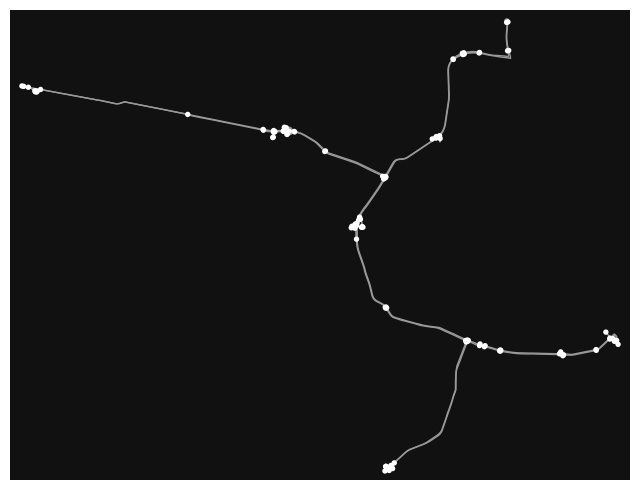

In [21]:
fig, ax = ox.plot_graph(G)

Poniżej przykład reprezentujący siatkę połączeń typu "railway": "subway" czyli metra w Nowym Jorku>

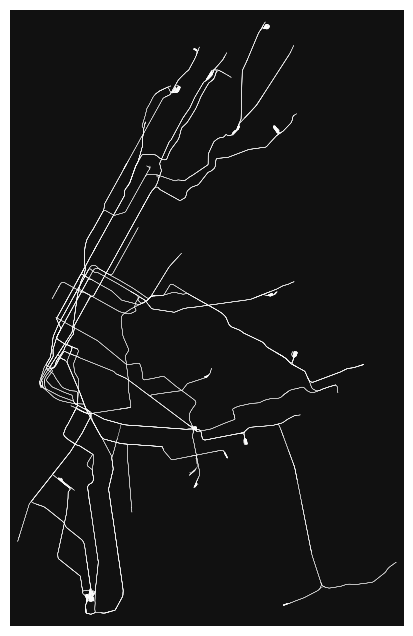

In [22]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"] # type: ignore
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

In [23]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()  # type: ignore

osmid  \
u        v          key                                                      
42507216 3514377668 0                                            344690669   
         3514445036 0                                            813273119   
         1413569906 0    [344659072, 344623108, 344620812, 344621709, 3...   
42795301 2946920015 0    [46892613, 46892614, 46892617, 46892622, 46892...   
         42795313   0                                              5700312   

                           service railway  oneway reversed    length  \
u        v          key                                                 
42507216 3514377668 0    crossover  subway   False     True    65.292   
         3514445036 0          NaN  subway   False    False    25.108   
         1413569906 0          NaN  subway   False     True  5749.956   
42795301 2946920015 0          NaN  subway   False    False   866.908   
         42795313   0          NaN  subway   False     True  1056.558   

                                      name tunnel bridge  \
u        v          key                                    
42507216 3514377668 0                  NaN    NaN    NaN   
         3514445036 0    BMT Brighton Line    NaN    NaN   
         1413569906 0    BMT Brighton Line    yes    yes   
42795301 2946920015 0    IND Rockaway Line    NaN    yes   
         42795313   0    IND Rockaway Line    NaN    NaN   

                                                                  geometry  \
u        v          key                                                      
42507216 3514377668 0    LINESTRING (-73.96163 40.65839, -73.96149 40.6...   
         3514445036 0    LINESTRING (-73.96163 40.65839, -73.96166 40.6...   
         1413569906 0    LINESTRING (-73.96163 40.65839, -73.96136 40.6...   
42795301 2946920015 0    LINESTRING (-73.82962 40.65922, -73.82970 40.6...   
         42795313   0    LINESTRING (-73.82962 40.65922, -73.82931 40.6...   

                        maxspeed  
u        v          key           
42507216 3514377668 0        NaN  
         3514445036 0        NaN  
         1413569906 0        NaN  
42795301 2946920015 0        NaN  
         42795313   0        NaN

## Cechy przestrzenne (obiekty)

OSMNX pozwala także na wyciągnięcie GeoDataFrame obiektów dla zadanego obszaru. Poszczególne kolumny zależą od typu obiektów, które są pobierane, jednak cechą wspólną jest m.in. geometria obiektu, osmid oraz typ elementu. Do prezentacji na mapie wykorzystano ox.plot_footprints.

In [24]:
# get all building footprints in some neighborhood
place = "Wrocław, Poland"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

(148318, 436)

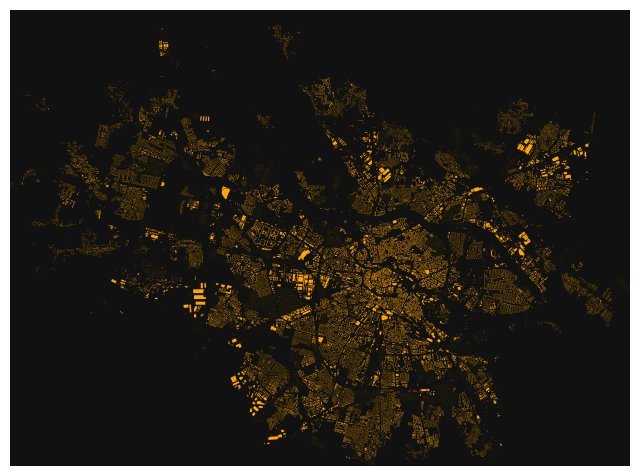

In [25]:
fig, ax = ox.plot_footprints(gdf)

In [26]:
gdf

entrance level  \
element_type osmid                        
node         7552223064       NaN   NaN   
             9704194694       NaN   NaN   
             10001401486      NaN   NaN   
             10965056566      NaN   NaN   
             10965056567      NaN   NaN   
...                           ...   ...   
relation     15395438         NaN   NaN   
             15602205         NaN   NaN   
             15852014         NaN   NaN   
             15852015         NaN   NaN   
             16291071         NaN   NaN   

                                                                   geometry  \
element_type osmid                                                            
node         7552223064                           POINT (16.97494 51.19952)   
             9704194694                           POINT (16.99264 51.15054)   
             10001401486                          POINT (17.12710 51.15119)   
             10965056566                          POINT (17.02263 51.04969)   
             10965056567                          POINT (17.02243 51.04918)   
...                                                                     ...   
relation     15395438     POLYGON ((16.97894 51.09333, 16.97894 51.09331...   
             15602205     POLYGON ((17.05676 51.12539, 17.05677 51.12539...   
             15852014     POLYGON ((17.06037 51.11596, 17.06040 51.11608...   
             15852015     POLYGON ((17.06035 51.11612, 17.06036 51.11614...   
             16291071     POLYGON ((17.00758 51.11262, 17.00805 51.11257...   

                            amenity capacity  fee artist_name artwork_type  \
element_type osmid                                                           
node         7552223064         NaN      NaN  NaN         NaN          NaN   
             9704194694         NaN      NaN  NaN         NaN          NaN   
             10001401486  fast_food      NaN  NaN         NaN          NaN   
             10965056566        NaN      NaN  NaN         NaN          NaN   
             10965056567        NaN      NaN  NaN         NaN          NaN   
...                             ...      ...  ...         ...          ...   
relation     15395438           NaN      NaN  NaN         NaN          NaN   
             15602205           NaN      NaN  NaN         NaN          NaN   
             15852014           NaN      NaN  NaN         NaN          NaN   
             15852015           NaN      NaN  NaN         NaN          NaN   
             16291071           NaN      NaN  NaN         NaN          NaN   

                         brand:wikidata brand:wikipedia  ... toilets:fee  \
element_type osmid                                       ...               
node         7552223064             NaN             NaN  ...         NaN   
             9704194694             NaN             NaN  ...         NaN   
             10001401486            NaN             NaN  ...         NaN   
             10965056566            NaN             NaN  ...         NaN   
             10965056567            NaN             NaN  ...         NaN   
...                                 ...             ...  ...         ...   
relation     15395438               NaN             NaN  ...         NaN   
             15602205               NaN             NaN  ...         NaN   
             15852014               NaN             NaN  ...         NaN   
             15852015               NaN             NaN  ...         NaN   
             16291071               NaN             NaN  ...         NaN   

                         kids_area service:electricity clothes  \
element_type osmid                                               
node         7552223064        NaN                 NaN     NaN   
             9704194694        NaN                 NaN     NaN   
             10001401486       NaN                 NaN     NaN   
             10965056566       NaN                 NaN     NaN   
             10965056567       NaN   

In [27]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape

(1782, 92)

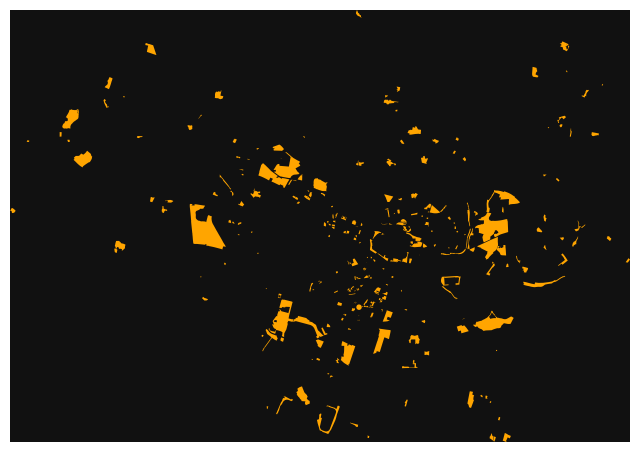

In [28]:
fig, ax = ox.plot_footprints(gdf)

Jeśli mamy odpowiednie gdf spełniające [wymagania](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.utils_graph.graph_from_gdfs) można samodzielnie utworzyć graf z wierzchołków i krawędzi za pomocą **osmnx.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)**

## Mapy izochroniczne 
**Jak daleko można dojść pieszo w ciągu 15min we Wrocławiu?**

Mapy izochroniczne reprezentują "mapę ciepła" odnośnie określonego zjawiska, jak np. wyżej wspomiane dojście pieszo od centrum sieci.
"Dojście piesze" zareprezentowano poprzez zmianę typu sieci na "walk". Dodatkowo określono pręzdkość w km/h i zaznaczono biny które póżniej zostały naniesione na mapę. 

Całość jest przydatna w momencie, gdy chcemy określać obszar

In [29]:
# configure the place, network type, trip times, and travel speed
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour
G = ox.graph_from_place("Wrocław, Poland", network_type=network_type)

In [30]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()  # type: ignore

osmid  oneway lanes  ref  \
u        v          key                                 
95584835 6152142174 0     28458110   False     2   94   
         2613222792 0     24707867   False     2  NaN   
         3019848617 0     28458112   False     3  395   
         304634270  0    301726798   False     4   94   
95584841 164895026  0     27665976   False   NaN  NaN   

                                               name       highway maxspeed  \
u        v          key                                                      
95584835 6152142174 0          Aleja Armii Krajowej       primary       50   
         2613222792 0                       Bardzka      tertiary       50   
         3019848617 0                       Bardzka     secondary       50   
         304634270  0          Aleja Armii Krajowej       primary       50   
95584841 164895026  0    Biskupa Bernarda Bogedaina  unclassified      NaN   

                        reversed  length  \
u        v          key                    
95584835 6152142174 0      False  12.949   
         2613222792 0      False  22.518   
         3019848617 0       True  25.200   
         304634270  0       True  36.058   
95584841 164895026  0      False  14.714   

                                                                  geometry  \
u        v          key                                                      
95584835 6152142174 0    LINESTRING (17.04951 51.08311, 17.04933 51.08311)   
         2613222792 0    LINESTRING (17.04951 51.08311, 17.04947 51.083...   
         3019848617 0    LINESTRING (17.04951 51.08311, 17.04953 51.083...   
         304634270  0    LINESTRING (17.04951 51.08311, 17.04994 51.083...   
95584841 164895026  0    LINESTRING (17.06437 51.08470, 17.06450 51.08460)   

                        access service bridge junction width tunnel railway  \
u        v          key                                                       
95584835 6152142174 0      NaN     NaN    NaN      NaN   NaN    NaN     NaN   
         2613222792 0      NaN     NaN    NaN      NaN   NaN    NaN     NaN   
         3019848617 0      NaN     NaN    NaN      NaN   NaN    NaN     NaN   
         304634270  0      NaN     NaN    NaN      NaN   NaN    NaN     NaN   
95584841 164895026  0      NaN     NaN    NaN      NaN   NaN    NaN     NaN   

                        area landuse  
u        v          key               
95584835 6152142174 0    NaN     NaN  
         2613222792 0    NaN     NaN  
         3019848617 0    NaN     NaN  
         304634270  0    NaN     NaN  
95584841 164895026  0    NaN     NaN

In [31]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy # type: ignore
center_node = ox.distance.nearest_nodes(G, x[0], y[0]) # type: ignore
G = ox.project_graph(G)

Poniżej kod pozwalający na wyliczenie czasu przejścia przez dany odcinek drogi (od węzła do węzła czyli np. od skżyżowania do skrzyżowania/ ślepej uliczki itp). Czas jest wyrażony w minutach. Założono średniąprędkość 4.5 km/h (zdefiniowane wcześniej).

In [32]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [33]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.head()  # type: ignore

osmid  oneway lanes  ref                  name  \
u          v          key                                                       
95584835   6152142174 0     28458110   False     2   94  Aleja Armii Krajowej   
           2613222792 0     24707867   False     2  NaN               Bardzka   
           3019848617 0     28458112   False     3  395               Bardzka   
           304634270  0    301726798   False     4   94  Aleja Armii Krajowej   
6152142174 95584835   0     28458110   False     2   94  Aleja Armii Krajowej   

                             highway maxspeed reversed  length      time  \
u          v          key                                                  
95584835   6152142174 0      primary       50    False  12.949  0.172653   
           2613222792 0     tertiary       50    False  22.518  0.300240   
           3019848617 0    secondary       50     True  25.200  0.336000   
           304634270  0      primary       50     True  36.058  0.480773   
6152142174 95584835   0      primary       50     True  12.949  0.172653   

                                                                    geometry  \
u          v          key                                                      
95584835   6152142174 0    LINESTRING (643550.007 5661065.194, 643537.019...   
           2613222792 0    LINESTRING (643550.007 5661065.194, 643546.419...   
           3019848617 0    LINESTRING (643550.007 5661065.194, 643551.616...   
           304634270  0    LINESTRING (643550.007 5661065.194, 643579.774...   
6152142174 95584835   0    LINESTRING (643537.019 5661065.222, 643550.007...   

                          access bridge service railway width junction tunnel  \
u          v          key                                                       
95584835   6152142174 0      NaN    NaN     NaN     NaN   NaN      NaN    NaN   
           2613222792 0      NaN    NaN     NaN     NaN   NaN      NaN    NaN   
           3019848617 0      NaN    NaN     NaN     NaN   NaN      NaN    NaN   
           304634270  0      NaN    NaN     NaN     NaN   NaN      NaN    NaN   
6152142174 95584835   0      NaN    NaN     NaN     NaN   NaN      NaN    NaN   

                          landuse area  
u          v          key               
95584835   6152142174 0       NaN  NaN  
           2613222792 0       NaN  NaN  
           3019848617 0       NaN  NaN  
           304634270  0       NaN  NaN  
6152142174 95584835   0       NaN  NaN

In [34]:
travel_speed

4.5

Poniżej różne sposoby prezentacji heatmapy na podstawie długości rasy od punktu centralnego obszaru Wrocławia.

In [35]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

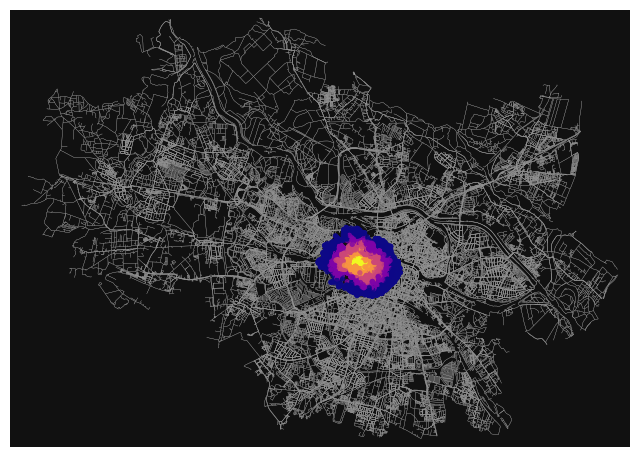

In [36]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc, # type: ignore
    node_size=ns, # type: ignore
    node_alpha=0.8,
    edge_linewidth=0.2, # type: ignore
    edge_color="#999999",
)

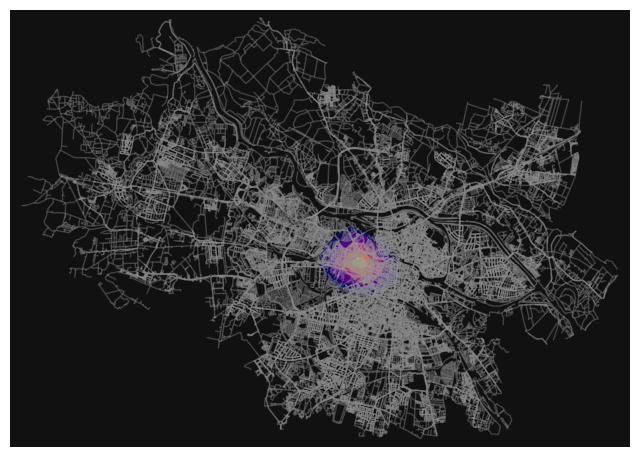

In [37]:
import matplotlib.pyplot as plt
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull # type: ignore
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys) # type: ignore
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

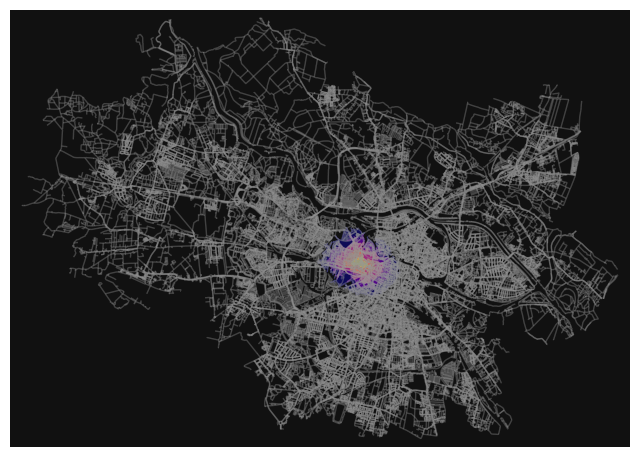

In [38]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # type: ignore
        nodes_gdf = nodes_gdf.set_index("id") # type: ignore

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry # type: ignore
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior) # type: ignore
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys) # type: ignore

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Query na podstawie daty

Zgodnie z wykorzystywaną wersją poaczki **osmnx==1.6.0** pobranie danych historycznych może nastąpić z wykorzystaniem modułu **settings**, który pozwala na dobór ustawień pozyskiwania danych, w tym daty. POniżej przedstawiono kod, któy obejmuje załadowanie wybranych cech - amenity: restaurant z obszaru wrocławia dla roku 2015 i 2022, a następnie określenie zmian w atrybutach, które nastąpiły na przestrzeni lat dla obiektów o tym samym położeniu.

In [39]:
place = "Wroclaw, Poland"
tags = {"amenity": "restaurant"}
cs = '[out:json][timeout:180][date:"2016-10-28T19:20:00Z"]'
ox.settings.overpass_settings = cs # type: ignore
gdf = ox.features_from_place(place, tags=tags)
gdf.head()

amenity                 name  \
element_type osmid                                        
node         262942961  restaurant  Piramida Steakhouse   
             280727473  restaurant               Chatka   
             300461029  restaurant     Galeria Italiana   
             300461031  restaurant             Pattie's   
             300461042  restaurant        Pha Tha Thai    

                                                            opening_hours  \
element_type osmid                                                          
node         262942961                Su-Tu 12:00-22:30; Fr-Sa 12:00-0:00   
             280727473                                                NaN   
             300461029                                                NaN   
             300461031                                  Mo-Su 10:00-21:00   
             300461042  Mo-Th 11:00-21:00; Fr-Sa 11:00-22:00; Su 11:00...   

                       wheelchair                   geometry addr:street  \
element_type osmid                                                         
node         262942961         no  POINT (17.03601 51.10988)         NaN   
             280727473         no  POINT (17.03136 51.11196)         NaN   
             300461029    limited  POINT (17.03220 51.11205)         NaN   
             300461031        NaN  POINT (17.03221 51.11145)     Igielna   
             300461042        NaN  POINT (17.03237 51.11209)   Więzienna   

                         cuisine smoking addr:postcode addr:housenumber  ...  \
element_type osmid                                                       ...   
node         262942961       NaN     NaN           NaN              NaN  ...   
             280727473       NaN     NaN           NaN              NaN  ...   
             300461029       NaN     NaN           NaN              NaN  ...   
             300461031  pancakes      no        50-325               16  ...   
             300461042      thai     NaN           NaN                5  ...   

                       nodes WroclawGIS:building:layer  \
element_type osmid                                       
node         262942961   NaN                       NaN   
             280727473   NaN                       NaN   
             300461029   NaN                       NaN   
             300461031   NaN                       NaN   
             300461042   NaN                       NaN   

                       WroclawGIS:building:date source:building  \
element_type osmid                                                
node         262942961                      NaN             NaN   
             280727473                      NaN             NaN   
             300461029                      NaN             NaN   
             300461031                      NaN             NaN   
             300461042                      NaN             NaN   

                       WroclawGIS:building:ID roof:colour building  \
element_type osmid                                                   
node         262942961                    NaN         NaN      NaN   
             280727473                    NaN         NaN      NaN   
             300461029                    NaN         NaN      NaN   
             300461031                    NaN         NaN      NaN   
             300461042                    NaN         NaN      NaN   

                       building:colour building:levels buildingpart  
element_type osmid                                                   
node         262942961             NaN             NaN          NaN  
             280727473             NaN             NaN          NaN  
             300461029             NaN             NaN          NaN  
             300461031             NaN             NaN          NaN  
             300461042             NaN             NaN          NaN  

[5 rows x 81 columns]

In [40]:
len(gdf)

263

In [41]:
gdf.columns

Index(['amenity', 'name', 'opening_hours', 'wheelchair', 'geometry',
       'addr:street', 'cuisine', 'smoking', 'addr:postcode',
       'addr:housenumber', 'addr:city', 'internet_access', 'phone', 'website',
       'contact:phone', 'contact:website', 'contact:email', 'restaurant',
       'addr:country', 'url', 'tourism', 'takeaway', 'WroclawGIS:addr:date',
       'WroclawGIS:addr:id', 'WroclawGIS:addr:layer',
       'WroclawGIS:addr:postcode:id', 'WroclawGIS:addr:postcode:layer',
       'source:addr', 'addr:street:sym_ul', 'delivery', 'email', 'name:en',
       'source:opening_hours', 'operator', 'brand', 'diet:vegetarian',
       'contact:facebook', 'diet:vegan', 'outdoor_seating', 'description',
       'toilets:wheelchair', 'source', 'wifi', 'chairs', 'diet:gluten_free',
       'diet:halal', 'diet:kosher', 'facebook', 'old_name', 'source_ref',
       'source_ref:opening_hours', 'payment:debit_cards',
       'payment:credit_cards', 'payment:coins', 'diet:vegetarian:description',
    

In [42]:
cs = '[out:json][timeout:180][date:"2022-10-28T19:20:00Z"]'
ox.settings.overpass_settings = cs # type: ignore
gdf_new = ox.features_from_place(place, tags=tags)
gdf_new.head()

wheelchair toilets:wheelchair addr:city  \
element_type osmid                                               
node         280727473         no                 no   Wrocław   
             300461031        NaN                NaN   Wrocław   
             300461042         no                NaN   Wrocław   
             300461045    limited                NaN   Wrocław   
             300461102        NaN                NaN       NaN   

                       addr:housenumber addr:postcode addr:street     amenity  \
element_type osmid                                                              
node         280727473                7        50-113   Odrzańska  restaurant   
             300461031               16        50-325     Igielna  restaurant   
             300461042               5b        50-118   Więzienna  restaurant   
             300461045                5        50-064   Świdnicka  restaurant   
             300461102              NaN           NaN         NaN  restaurant   

                       changing_table                cuisine indoor_seating  \
element_type osmid                                                            
node         280727473             no                 polish            yes   
             300461031            NaN                    NaN            NaN   
             300461042            NaN                   thai            NaN   
             300461045            NaN   sandwich;pasta;toast            NaN   
             300461102            NaN  japanese;korean;sushi            NaN   

                        ... source:building addr:city:simc source:addr height  \
element_type osmid      ...                                                     
node         280727473  ...             NaN            NaN         NaN    NaN   
             300461031  ...             NaN            NaN         NaN    NaN   
             300461042  ...             NaN            NaN         NaN    NaN   
             300461045  ...             NaN            NaN         NaN    NaN   
             300461102  ...             NaN            NaN         NaN    NaN   

                       source:height building:colour buildingpart  \
element_type osmid                                                  
node         280727473           NaN             NaN          NaN   
             300461031           NaN             NaN          NaN   
             300461042           NaN             NaN          NaN   
             300461045           NaN             NaN          NaN   
             300461102           NaN             NaN          NaN   

                       building:levels url:0 indoor  
element_type osmid                                   
node         280727473             NaN   NaN    NaN  
             300461031             NaN   NaN    NaN  
             300461042             NaN   NaN    NaN  
             300461045             NaN   NaN    NaN  
             300461102             NaN   NaN    NaN  

[5 rows x 119 columns]

In [43]:
len(gdf_new)

463

In [44]:
common_columns = gdf.columns.intersection(gdf_new.columns)

# Print the common columns
print("Common Columns:", common_columns)

Common Columns: Index(['amenity', 'name', 'opening_hours', 'wheelchair', 'geometry',
       'addr:street', 'cuisine', 'smoking', 'addr:postcode',
       'addr:housenumber', 'addr:city', 'internet_access', 'phone', 'website',
       'contact:phone', 'contact:website', 'contact:email', 'addr:country',
       'url', 'takeaway', 'source:addr', 'addr:street:sym_ul', 'delivery',
       'email', 'source:opening_hours', 'operator', 'brand', 'diet:vegetarian',
       'contact:facebook', 'diet:vegan', 'outdoor_seating', 'description',
       'toilets:wheelchair', 'source', 'diet:gluten_free', 'diet:halal',
       'diet:kosher', 'facebook', 'old_name', 'source_ref',
       'payment:debit_cards', 'payment:credit_cards', 'payment:coins',
       'website:1', 'shop', 'note', 'capacity', 'reservation',
       'internet_access:fee', 'payment:american_express', 'payment:cash',
       'payment:mastercard', 'payment:visa', 'diet:vegan:description',
       'microbrewery', 'name:pl', 'nodes', 'source:buildi

In [45]:
merged_gdf = gpd.sjoin(gdf, gdf_new, how='inner', op='intersects')

# Group by the 'geometry' column from the second DataFrame and get 5 records for each group
result = merged_gdf.groupby('geometry').apply(lambda x: x.head(5))

# Reset the index to make the 'geometry' column a regular column
result = result.reset_index(drop=True)
result.head()

/home/gry-mar/osm-proj/gradient/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,amenity_left,name_left,opening_hours_left,wheelchair_left,geometry,addr:street_left,cuisine_left,smoking_left,addr:postcode_left,addr:housenumber_left,...,source:building_right,addr:city:simc,source:addr_right,height,source:height,building:colour_right,buildingpart_right,building:levels_right,url:0,indoor
0,restaurant,Pizzeria Capriatti,NaN,limited,POINT (16.97741 51.06321),NaN,pizza,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,restaurant,Fu Kuoc,NaN,NaN,POINT (16.97844 51.09490),Aleksandra Ostrowskiego,asian,NaN,53-238,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,restaurant,Pizzeria Novecento,NaN,NaN,POINT (16.86668 51.14516),Michała Płońskiego,pizza,NaN,NaN,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,restaurant,Esencja Sushi,NaN,NaN,POINT (16.86670 51.14525),Michała Płońskiego,sushi,NaN,NaN,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,restaurant,Familia,NaN,NaN,POINT (16.86990 51.14531),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_cleaned = result.dropna(axis=1, how='all')
df_cleaned.head()

,amenity_left,name_left,opening_hours_left,wheelchair_left,geometry,addr:street_left,cuisine_left,smoking_left,addr:postcode_left,addr:housenumber_left,...,building_right,source:building_right,addr:city:simc,source:addr_right,height,source:height,building:colour_right,buildingpart_right,building:levels_right,url:0
0,restaurant,Pizzeria Capriatti,NaN,limited,POINT (16.97741 51.06321),NaN,pizza,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,restaurant,Fu Kuoc,NaN,NaN,POINT (16.97844 51.09490),Aleksandra Ostrowskiego,asian,NaN,53-238,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,restaurant,Pizzeria Novecento,NaN,NaN,POINT (16.86668 51.14516),Michała Płońskiego,pizza,NaN,NaN,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,restaurant,Esencja Sushi,NaN,NaN,POINT (16.86670 51.14525),Michała Płońskiego,sushi,NaN,NaN,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,restaurant,Familia,NaN,NaN,POINT (16.86990 51.14531),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
unique_cols = set(col.split(':')[0] for col in result.columns)

# Find columns that have both 'left' and 'right' versions
both_versions_cols = [col for col in unique_cols if f'{col}_left' in result.columns and f'{col}_right' in result.columns]

print("Columns with both 'left' and 'right' versions:", both_versions_cols)

Columns with both 'left' and 'right' versions: ['capacity', 'website', 'opening_hours', 'building', 'name', 'source_ref', 'brand', 'internet_access', 'source', 'url', 'old_name']


In [48]:
# Initialize an empty DataFrame to store the results
df_year_changes = pd.DataFrame()
columns = []
# Iterate over unique column names that appears in both dataframes (2015 and 2022)
for col in both_versions_cols:
    left_col = f'{col}_left'
    right_col = f'{col}_right'
    columns.append(left_col)
    columns.append(right_col)

    # Filter rows where the values in the 'left' column are different from the 'right' column
    diff_rows = result[result[left_col] != result[right_col]]

    # Append the result to the final DataFrame
    df_year_changes = pd.concat([df_year_changes, diff_rows], ignore_index=True)

columns.append("geometry")
df_year_changes[columns]

,capacity_left,capacity_right,website_left,website_right,opening_hours_left,opening_hours_right,building_left,building_right,name_left,name_right,...,brand_right,internet_access_left,internet_access_right,source_left,source_right,url_left,url_right,old_name_left,old_name_right,geometry
0,NaN,NaN,NaN,http://www.pizzeriacapratti.pl/,NaN,NaN,NaN,NaN,Pizzeria Capriatti,Pizzeria Capratti,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.97741 51.06321)
1,NaN,NaN,NaN,http://www.halong.net.pl,NaN,"Mo-Sa 10:00-20:00, Su 12:00-20:00",NaN,NaN,Fu Kuoc,Ha Long,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.97844 51.09490)
2,NaN,NaN,https://www.facebook.com/NovecentoPizzeria/,https://www.facebook.com/NovecentoPizzeria/,NaN,Mo-Sa 12:00-20:00; Su 13:00-20:00,NaN,NaN,Pizzeria Novecento,Pizzeria Novecento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.86668 51.14516)
3,NaN,NaN,https://www.facebook.com/RestauracjaEsencjaSushi/,NaN,NaN,"Su-Th 12:00-21:00; Fr,Sa 12:00-22:00; PH off",NaN,NaN,Esencja Sushi,Heavy Meat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.86670 51.14525)
4,NaN,NaN,NaN,http://www.restauracjafamilia.pl/,NaN,NaN,NaN,NaN,Familia,Familia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.86990 51.14531)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,NaN,NaN,http://tuttisanti.pl/restauracje/wroclaw,http://tuttisanti.pl/restauracje/wroclaw,"Su,Mo,Tu,We,Th 11:00-22:00; Fr,Sa 11:00-23:00","Su,Mo,Tu,We,Th 11:00-22:00; Fr,Sa 11:00-23:00",NaN,NaN,Tutti Santi,Tutti Santi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.00036 51.08730)
550,NaN,NaN,NaN,https://www.pizza-time.pl,NaN,"Mo-Th,Su 12:00-22:00; Fr-Sa 12:00-00:00",NaN,NaN,Sopranos's Pizza,Pizza Time,...,NaN,NaN,NaN,local_knowledge,local_knowledge,NaN,NaN,NaN,NaN,POINT (16.99357 51.07203)
551,NaN,NaN,http://beneposto.pl/,NaN,NaN,Mo-Su 12:00-22:00,NaN,NaN,Ristorante benaPosto,Korea Garden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (16.98409 51.06430)
552,NaN,NaN,NaN,https://fit-back.pl,Mo-Su 12:00-22:30,NaN,NaN,NaN,Pory Roku,FitBack Food & Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.06125 51.05293)


Dane pobierane w czasie działają, widoczne są różnice w przypadku obiektów, takie jak zmiana nazwy miejsca czy wprowadzenie informacji odnośnie godzin otwarcia obiektu.

## R-tree spatial indexing

Po co to jest?

Indeks przestrzenny pozwala na przyspieszenie operacji takich jak przecięcia i połączenia. R-tree reprezentuje poszczególne obiekty i ich pola graniczne jako najniższy poziom indeksu przestrzennego. Następnie agreguje pobliskie obiekty i reprezentuje je za pomocą ich zagregowanego pola granicznego. Więcej informacji [tutaj](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/ ).

In [49]:
# get the boundary of some city
gdf = ox.geocode_to_gdf('Wrocław, Poland')

# get the street network within this bounding box
west, south, east, north = gdf.unary_union.buffer(0.1).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)

In [50]:
# get lat-long points for each intersection
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))

In [51]:
# turn the lat-long points into a geodataframe
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'


/tmp/ipykernel_121008/4258787521.py:3: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)


In [52]:
isinstance(gdf['geometry'].iloc[0], Polygon)

True

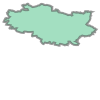

In [53]:
gdf['geometry'].iloc[0]

In [54]:
# make the geometry a multipolygon if it's not already
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

In [55]:
geometry.geoms

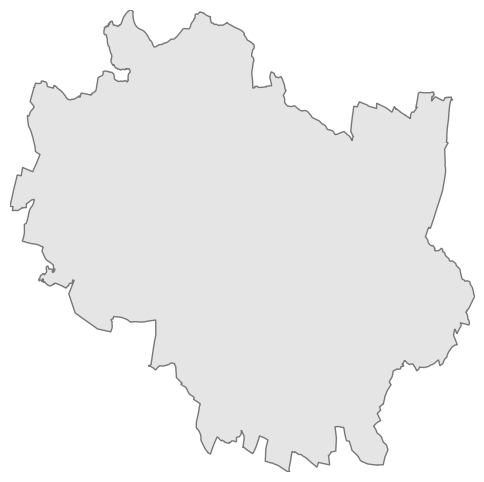

In [56]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)  
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

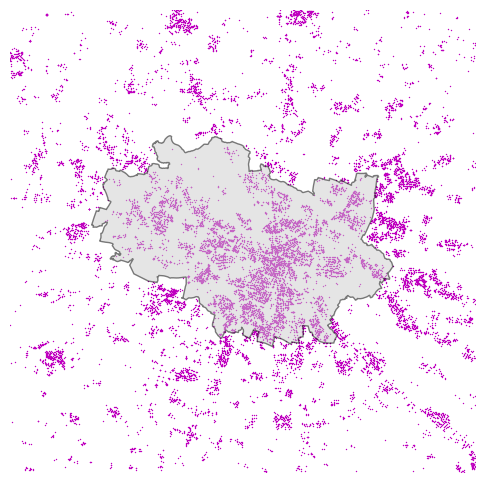

In [57]:
west, south, east, north = gdf_nodes.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1) # type: ignore
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

**Idea działania PolygonPatch**

Pozwala to na wyrysowanie krawędzi wokół interesującego nas obszaru na podstawie geometrii MultiPolygonu. Na początku notebooka została wyszczególniona zmiana jaką ręcznie należy wprowadzić w bibliotece realizującej patche.
Rozwiązanie jest możliwe też na samym scatter plocie, jednak wyrysowanie krawędzi znacznie poprawia jakość wizualizacji.

In [58]:
sindex = gdf_nodes.sindex
possible_matches_index = list(sindex.intersection(geometry.bounds))
possible_matches = gdf_nodes.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(geometry)] # type: ignore

In [59]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

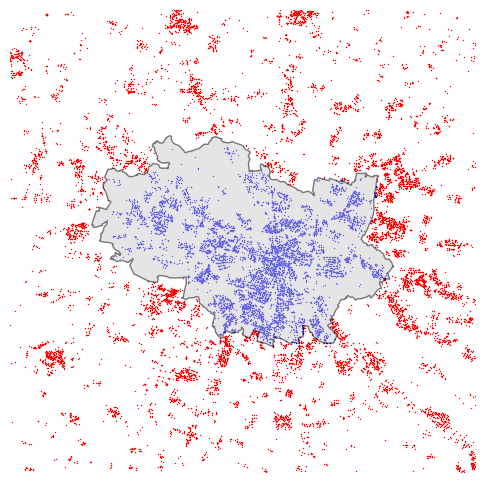

In [60]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)
ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Another example

In [61]:
# get the boundary of some city
gdf = ox.geocode_to_gdf('Wrocław, Poland')

# get the street network within this bounding box
west, south, east, north = gdf.unary_union.buffer(0.6).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', retain_all=True)
# get lat-long points for each intersection
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))
# turn the lat-long points into a geodataframe
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)
gdf_nodes.crs = gdf.crs
gdf_nodes.name = 'nodes'
west, south, east, north = gdf_nodes.unary_union.bounds

/tmp/ipykernel_121008/193421205.py:12: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)


In [62]:
# make the geometry a multipolygon if it's not already
geometry = gdf['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

In [63]:
gdf_nodes

,x,y,geometry
0,16.268420,50.625287,POINT (16.26842 50.62529)
1,16.269024,50.625784,POINT (16.26902 50.62578)
2,16.340937,50.590309,POINT (16.34094 50.59031)
3,16.322554,50.590538,POINT (16.32255 50.59054)
4,16.334694,50.582669,POINT (16.33469 50.58267)
...,...,...,...
59972,17.342604,50.472695,POINT (17.34260 50.47269)
59973,17.669384,50.534952,POINT (17.66938 50.53495)
59974,17.333740,50.473178,POINT (17.33374 50.47318)
59975,17.382324,50.615922,POINT (17.38232 50.61592)


In [64]:
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((16.80734 51.13895, 16.80859 51.13887...",51.21006,51.042669,17.176219,16.807339,196845665,relation,2805691,51.126311,16.978196,boundary,administrative,14,0.66475,administrative,Wrocław,"Wrocław, Lower Silesian Voivodeship, Poland"


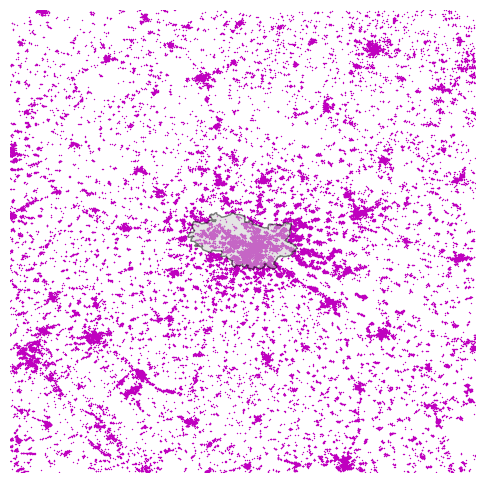

In [65]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1)    # type: ignore
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [66]:

geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=2) # type: ignore

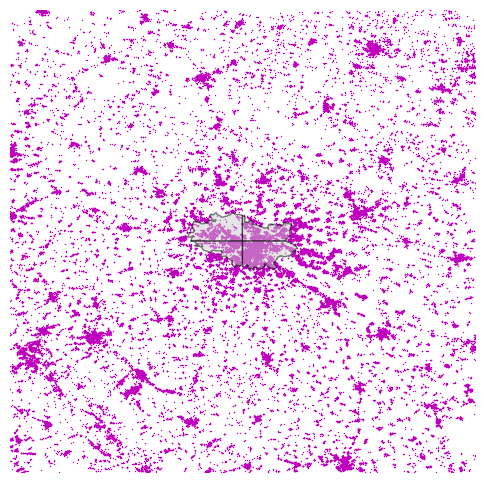

In [67]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=1, c='m', linewidth=0, zorder=1) # type: ignore
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [68]:
# build the r-tree index
sindex = gdf_nodes.sindex

In [69]:
# find the points that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()
for poly in geometry_cut.geoms:
    # buffer by the <1 micron dist to account for any space lost in the quadrat cutting
    # otherwise may miss point(s) that lay directly on quadrat line
    poly = poly.buffer(1e-14).buffer(0)

    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf_nodes.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)] # type: ignore

    # concatenate the results to points_within_geometry
    points_within_geometry = pd.concat([points_within_geometry, precise_matches], ignore_index=True)

In [70]:
# drop duplicate points, if buffered poly caused an overlap on point(s) that lay directly on a quadrat line
points_within_geometry = points_within_geometry.drop_duplicates(subset=['x', 'y'])
points_outside_geometry = gdf_nodes[~gdf_nodes.isin(points_within_geometry)]

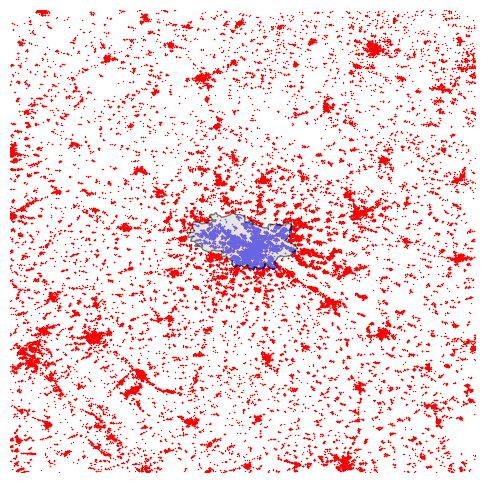

In [71]:
# plot the city and points within/outside
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry.geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1) # type: ignore
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

## Network-based spatial clustering 

Klastrowanie na danych przestrzennych. W ramach tej sekcji zaprezentowano najpierw wybór klastrów jako losowych wierzchołk ow w grafie a następnie dokonanie klasteryzacji za pomocą DBSCAN.
[Źródło](https://geoffboeing.com/2018/04/network-based-spatial-clustering/)

In [72]:
# parameterize DBSCAN
eps = 300 #meters
minpts = 3 #smallest cluster size allowed

# fake data: create n_firms evenly disbursed across n_clusters
n_firms = 30
n_clusters = 3

place = 'Wrocław, Poland'

In [73]:
# get the street network
G = ox.graph_from_place(place, network_type='drive', buffer_dist=500)

/tmp/ipykernel_121008/872293012.py:2: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your query area directly, if desired.
  G = ox.graph_from_place(place, network_type='drive', buffer_dist=500)
/home/gry-mar/osm-proj/gradient/env/lib/python3.8/site-packages/osmnx/graph.py:352: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  gdf_place = geocoder.geocode_to_gdf(


### Tworzenie fałszywych, losowych zgrupowań

In [74]:
# randomly select n_clusters number of nodes from the graph
np.random.seed(7)
firm_centers = np.random.choice(G.nodes(), size=n_clusters, replace=False)


# scatter some firms around the selected nodes
xs = []
ys = []
for osmid in firm_centers:
    x = G.nodes[osmid]['x']
    y = G.nodes[osmid]['y']
    np.random.seed(1)
    xs.extend(np.random.normal(loc=x, scale=0.001, size=int(n_firms/len(firm_centers))))
    ys.extend(np.random.normal(loc=y, scale=0.001, size=int(n_firms/len(firm_centers))))
    
firms = pd.DataFrame({'x':xs, 'y':ys})
len(firms)

30

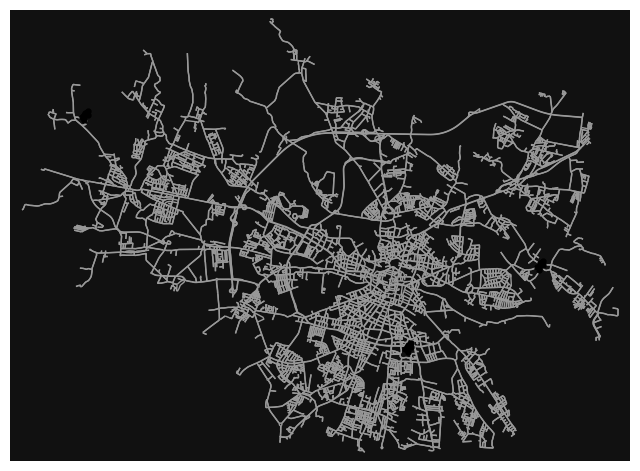

In [75]:
# plot the firms and the points around which they cluster
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c='k', marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

### Klasyczne klastrowanie

In [78]:
%%time
# compute DBSCAN using straight-line haversine distances
eps_rad = eps / 3671000. #meters to radians
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric='haversine', algorithm='ball_tree')
firms['spatial_cluster'] = db.fit_predict(np.deg2rad(firms[['y', 'x']]))

CPU times: user 6.65 ms, sys: 0 ns, total: 6.65 ms
Wall time: 5.87 ms


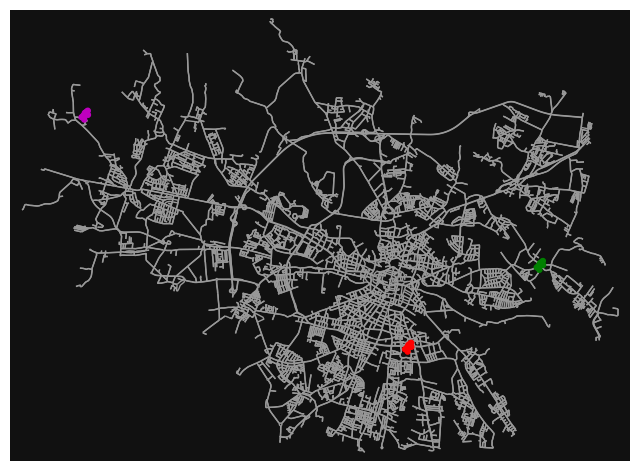

In [79]:
# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'m', 3:'b'}
point_colors = [color_map[c] for c in firms['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

### Tworzenie rzadkiej macierzy odległości

W zwykłej macierzy odległości elementy zerowe są uważane za sąsiadów (znajdują się jeden na drugim). W przypadku macierzy rzadkiej tylko elementy niezerowe mogą być uważane za sąsiadów dla DBSCAN. 

In [80]:
# attach nearest network node to each firm
firms['nn'] = ox.nearest_nodes(G, X=firms['x'], Y=firms['y'])
print(len(firms['nn']))

# we'll get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms['nn'].unique())
nodes_unique.index = nodes_unique.values # type: ignore
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

30
14


In [81]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
    
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [82]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

196
CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.57 s


Macierz odległości

In [83]:


node_dm[nx.node_degree_xy == 0] = 1 # type: ignore
node_dm[node_dm > eps] = 0 # type: ignore
# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=firms['nn'], columns=firms['nn']) # type: ignore
print('{:,.0f}'.format(ndm.size))

900


In [84]:
%%time
# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)

CPU times: user 2.57 ms, sys: 42 µs, total: 2.62 ms
Wall time: 2.18 ms


In [85]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.to_numpy().nbytes / 1e6
dense_size

0.0072

In [86]:
# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6 # type: ignore
sparse_size

0.001228

In [87]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
firms['network_cluster'] = db.fit_predict(ndm_sparse)

CPU times: user 0 ns, sys: 5.01 ms, total: 5.01 ms
Wall time: 8.66 ms


/home/gry-mar/osm-proj/gradient/env/lib/python3.8/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [88]:
len(firms['network_cluster'].unique())

5

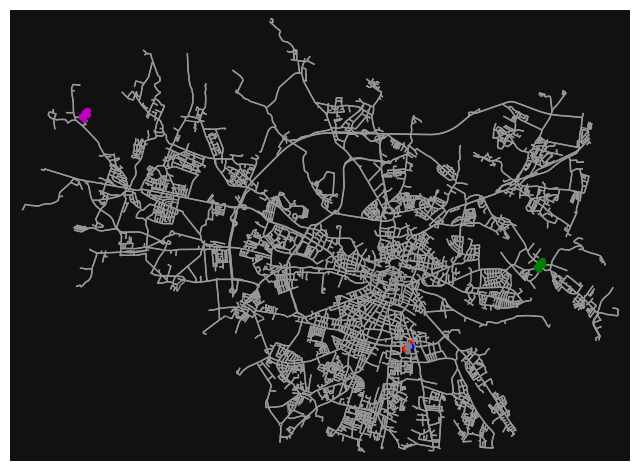

In [89]:
# plot firms by cluster
color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
point_colors = [color_map[c] for c in firms['network_cluster']]
ns = [50 if n in firms['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [90]:
#show the clustered firms data set
firms = firms.reindex(columns=['x', 'y', 'nn', 'spatial_cluster', 'network_cluster'])
firms[10:15]

,x,y,nn,spatial_cluster,network_cluster
10,17.047333,51.084435,297779691,1,-1
11,17.045097,51.080912,298897173,1,-1
12,17.045180,51.082650,298897163,1,-1
13,17.044636,51.082588,3020068321,1,1
14,17.046574,51.084106,296628978,1,1


## Wyznaczanie trasy pieszej pomiędzy 2 punktami 



* Graphhopper 
* OSRM
* Valhalla




### OSRM

OSRM pozwala m.in na wyznaczenie trasy pomiędzy zadanymi punktami. W zadanym przykładzie założono trasę pieszą (foot), jednak możliwe jest jeszcze ustawienie innych rodzajów przemieszczania się (np. bike). Całość przetestowano dla różnych przypadków, jednak nie zaobserwowano znaczących różnic w przebiegu trasy. 

In [98]:
def get_osrm_route(start, end):
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=1.0)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    url = f'http://router.project-osrm.org/route/v1/foot/{start};{end}?overview=full&geometries=geojson&annotations=duration&alternatives=true'
    response = session.get(url)
    data = response.json()
    return data

start_point = '17.0586408,51.110222'  # Replace with the actual coordinates
end_point = '17.0398486,51.11613149999999'    # Replace with the actual coordinates

osrm_route = get_osrm_route(start_point, end_point)
print(osrm_route)

{'code': 'Ok', 'routes': [{'geometry': {'coordinates': [[17.058662, 51.110228], [17.058792, 51.110051], [17.058829, 51.110009], [17.05898, 51.110054], [17.0594, 51.110167], [17.059485, 51.11019], [17.059558, 51.110098], [17.059645, 51.109973], [17.059658, 51.109956], [17.059698, 51.109906], [17.059732, 51.109864], [17.059834, 51.109758], [17.059845, 51.109746], [17.059934, 51.109659], [17.06004, 51.109573], [17.060137, 51.109522], [17.060233, 51.109479], [17.060539, 51.109375], [17.060723, 51.10931], [17.061071, 51.109189], [17.061341, 51.109096], [17.061537, 51.109028], [17.061562, 51.109019], [17.06171, 51.108967], [17.061755, 51.109023], [17.06177, 51.109041], [17.061779, 51.109053], [17.062352, 51.109749], [17.062428, 51.109861], [17.062441, 51.109879], [17.062515, 51.10997], [17.062673, 51.110167], [17.062687, 51.110185], [17.062706, 51.110208], [17.062731, 51.110238], [17.062733, 51.110241], [17.062746, 51.110257], [17.06281, 51.110333], [17.062875, 51.110405], [17.062932, 51.110

Oprócz samej trasy jest możliwe m.in. zwrócenie różnych anotacji, jak np **duration** - podane w sekundach ile zajmuje przebycie danego segmentu. W response mamy też m.in. **hint** zakodowany jako base64. Jednak nie jest to bezpośrednia wskazówka dla użytkownika tylko element, który potencjalnie może zostać przekazanyh do kolejnego zapytania jako "wskazówka" - więcej w [dokumentacji](https://project-osrm.org/docs/v5.5.1/api/#waypoint-object).

In [ ]:
osrm_route['routes'][0]['legs']

In [ ]:
osrm_route

In [101]:
def plot_route_on_map(route, map_obj):
    # Extract the coordinates from the route data
    coordinates = [(point[1], point[0]) for point in route['routes'][0]['geometry']['coordinates']]

    # Add markers for start and end points
    start_point = coordinates[0]
    end_point = coordinates[-1]

    folium.Marker(location=start_point, popup='Start Point', icon=folium.Icon(color='green')).add_to(map_obj)
    folium.Marker(location=end_point, popup='End Point', icon=folium.Icon(color='red')).add_to(map_obj)

    # Add the route to the map
    folium.PolyLine(locations=coordinates, color='blue', weight=5).add_to(map_obj)

    return map_obj

In [102]:
len(osrm_route['routes'])

1

In [103]:
## route statistics
print("Travel time (minutes): ", osrm_route['routes'][0]['legs'][0]['duration']/60 )

Travel time (minutes):  7.641666666666667


In [104]:
coordinates = osrm_route['routes'][0]['geometry']['coordinates']

# Create a Folium map centered on the first coordinate
my_map = folium.Map(location=[coordinates[0][1], coordinates[0][0]], zoom_start=15)

#swapping the coordinates to be lat lon not lon lat
coords_swapped = []
for each in coordinates:  
    point: tuple = tuple([each[1], each[0]])
    coords_swapped.append(point)
# Add a PolyLine to the map
folium.PolyLine(coords_swapped, color='red', weight=2.5, opacity=1).add_to(my_map)
my_map

**Potencjalne problemy i niewyjaśnione kwestie**

Typ drogi jest określony jao 'foot' jednak czas przebycia tak długiego odcinka to 6 minut + trasa wskazuje na trasę samochodu - nie wiadomo czy uległo to zmianie, jednak wg [źródła](https://gis.stackexchange.com/questions/260973/osrm-no-walking-directions) OSRM wspiera tylko trasy pokonywane samochodem.

### Graphhopper

Poniżej przedstawiono pojedyncze zapytanie dla drogi analogicznej do punktu wyżej, aby zobaczyć czy będzie ona zoptymalizowana pod realne piesze wycieczki. I jest, Graphhopper wspiera w wersji bezpłatnej środki transportu (profile) "car", "bike" i "foot", dodatkowo udostępnia wskazówki, np. "skręć w prawo", rodzaj nawierzchni na danym odcinku drowi i wiele innych. Więcej informacji w [dokumentacji](https://docs.graphhopper.com/#tag/Routing-API).

Całość trasy wraz z response można podejrzeć [tutaj](https://explorer.graphhopper.com/) po uprzednim zalogowaniu i wygenerowaniu klucza. 

**UWAGA**
W wersji bezpłatnej Graphhopper pzwala na 500 zapytań na dzień dla max. 5 lokalizacji per request. Więcej odnośnie płatności [tutaj](https://www.graphhopper.com/pricing/).


In [105]:
from dotenv import load_dotenv
import os
load_dotenv()
gh_api_key = os.getenv("GH_API_KEY")

# Specify the URL
url = 'https://graphhopper.com/api/1/route'

# Specify the request headers
query = {
    'key': gh_api_key,
}

headers = {"Content-Type": "application/json"}
# Specify the request body
payload = {
    "points": [
        [17.05864, 51.110222],
        [17.0398486, 51.11613149999999]
    ],
    "snap_preventions": ["motorway", "ferry", "tunnel"],
    "details": ["road_class", "surface"],
    "profile": "foot",
    "locale": "pl",
    "instructions": True,
    "calc_points": True,
    "points_encoded": False,
}

# Make the POST request
response = requests.post(url, json=payload, headers=headers, params=query)

data = response.json()
print(data)


{'hints': {'visited_nodes.sum': 170, 'visited_nodes.average': 170.0}, 'info': {'copyrights': ['GraphHopper', 'OpenStreetMap contributors'], 'took': 4, 'road_data_timestamp': '2024-01-13T13:00:00Z'}, 'paths': [{'distance': 1807.313, 'weight': 1094.040543, 'time': 1302006, 'transfers': 0, 'points_encoded': False, 'bbox': [17.039851, 51.110009, 17.059485, 51.116133], 'points': {'type': 'LineString', 'coordinates': [[17.058662, 51.110228], [17.058829, 51.110009], [17.059485, 51.11019], [17.059264, 51.110517], [17.05935, 51.11054], [17.059373, 51.110867], [17.059362, 51.110883], [17.059351, 51.110909], [17.059351, 51.110973], [17.059302, 51.111095], [17.05927, 51.111162], [17.059166, 51.111262], [17.059141, 51.111286], [17.059037, 51.111368], [17.05899, 51.111441], [17.058842, 51.111577], [17.058396, 51.111757], [17.058151, 51.111834], [17.05798, 51.111839], [17.057882, 51.111876], [17.057799, 51.111859], [17.056724, 51.112208], [17.056358, 51.112323], [17.056224, 51.11239], [17.056147, 51.

In [106]:
coordinates = data['paths'][0]['points']['coordinates']
coordinates = [[lat, lon] for lon, lat in coordinates]

In [107]:
map_center = [51.110228, 17.058662]
mymap = folium.Map(location=map_center, zoom_start=15)

# Add the route to the map
folium.PolyLine(locations=coordinates, color='blue', weight=5, opacity=0.7).add_to(mymap)

# Add markers for start and end points
folium.Marker(location=coordinates[0], popup='Start', icon=folium.Icon(color='green')).add_to(mymap)
folium.Marker(location=coordinates[-1], popup='End', icon=folium.Icon(color='red')).add_to(mymap)
mymap

### Valhalla

[Dokumentacja](https://valhalla.github.io/valhalla/api/optimized/api-reference/)


[Artykuł jak zbudować projekt](https://medium.com/@hernandezgalaviz/using-valhalla-map-matching-to-get-route-and-travelled-distance-from-raw-gps-points-4ea6b1c88a4c)

## Podsumowanie

* OSMNX pozwala na proste tworzenie i eksplorację grafów na danych przestrzennych. 
* Domyślnym targetem są grafy ulic 
* Istnieje możliwość samodzielnego zdefiniowania grafu przy odpowiednim zdefiniowaniu wierzchołków i krawędzi
* OSMNX udostępnia możliwość tworzenia gdf cech dla zadanego query z zadanego miejsca

Więcej przykładów użycia OSMNX dostępne na oficjalnym [repo](https://github.com/gboeing/osmnx-examples/tree/main/notebooks).
